In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

from scipy import stats as spstats

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application

In [2]:
%matplotlib notebook

# Test a dataset

# Set responsivity params

In [3]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5
experiment_type = 'blobs'

# Get aggregate data

In [4]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_inst

/n/coxfs01/julianarhee/aggregate-visual-areas


In [5]:
experiment_type

'blobs'

In [9]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
dsets = sdata[sdata['experiment']==experiment_type]

In [10]:
dsets['animalid'].unique()

array(['JC084', 'JC091', 'JC085', 'JC090', 'JC099', 'JC097', 'JC110',
       'JC076', 'JC078', 'JC080', 'JC083', 'JC113'], dtype=object)

In [11]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


# Create output dir for analysis


In [12]:
outdir = os.path.join(aggregate_dir, '%s-tuning' % experiment_type, stats_desc, 'linear-regression')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00/linear-regression


In [13]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [14]:
# Set plotting params
threshold_dff = True
min_dff = 0.03

n_sz = 5
n_mp = 10



# Select data

IGNORE THESE:
V1:  JC076-20190501, JC083-20190510
    - if blobs & rfs only: ignore JC083_20190511, else ALSO ignore: 20190507-JC083
Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if blobs & rfs only: ignore JC078-2019513, else ALSO ignore: JC078-20190430
    - if blobs & rfs only: ignore JC083-20190512, else ALSO ignore: JC083-20190508
Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [15]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                  'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']

also_exclude = ['JC083-20190510', 'JC083-20190511',
                'JC078-20190426', 'JC078-2019513', 'JC083-20190512']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

14


# Select dataset

In [161]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [162]:
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique()) 
if n_sizes != n_sz or n_morphs != n_mp:
    incorrect_nvalues.append(skey)
    pass

rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                             response_type=response_type, responsive_test=responsive_test,
                             responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T

# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))


... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 168 of 180 responsive cells.


In [163]:
skey = '-'.join([animalid, session, fov])
print skey

JC084-20190522-FOV1_zoom2p0x


# Get all trials

In [164]:
dflist = [pd.DataFrame(estats.gdf.get_group(roi).sort_values(by='trial')['dff']).reset_index(drop=True)\
          for roi in rois_plot]
          
df = pd.concat(dflist, axis=1)
df.columns = rois_plot

In [165]:
print df.shape
df.head()


(1500, 168)


,1,5,6,9,10,11,12,14,17,18,...,238,239,241,242,243,246,249,251,255,258
0,0.239952,-0.024001,0.019147,0.628262,0.127027,1.306773,0.611393,0.315377,0.549193,0.840671,...,0.463303,0.163610,0.575956,0.186751,0.129041,0.697019,0.777087,0.125536,0.095211,1.381889
1,0.284643,0.000722,-0.008510,0.522548,0.084995,-0.135453,0.414300,-0.063520,0.069752,0.231259,...,-0.081142,0.024475,0.040227,-0.003568,0.053908,0.060891,-0.086015,0.102580,0.019921,0.039035
2,0.208889,0.019041,-0.080974,0.246070,0.173447,-0.054215,0.110098,-0.007033,0.102650,0.003405,...,-0.052803,0.116760,0.104508,0.099735,-0.046675,0.267003,0.171934,0.241147,0.025097,0.127600
3,0.052450,0.009292,-0.025018,0.065487,0.078072,-0.030571,-0.151636,0.079483,1.125151,0.168588,...,0.217516,0.266838,0.154446,0.173936,0.283426,0.803298,0.138508,-0.027681,-0.065931,0.128240
4,0.075927,-0.013576,0.072178,0.087875,0.000507,-0.151116,-0.158963,0.094566,-0.023908,0.020529,...,0.236382,0.063161,0.056501,0.052397,0.027637,0.266262,-0.050102,-0.085769,0.011155,-0.170870


### Test regression stuff on 1 dset

In [166]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True

visual_areas = ['V1', 'Lm', 'Li']

In [167]:

excluded_configs = []
if exclude_controls:
    excluded_configs = sdf[sdf['morphlevel']==-1].index.tolist()
    sdf = sdf[sdf['morphlevel'] != -1]

In [168]:
sdf.head()

,color,morphlevel,object,size,stimtype,xpos,ypos,yrot
config006,,0,Blob_N1,10.0,image,20,-8,0
config007,,0,Blob_N1,20.0,image,20,-8,0
config008,,0,Blob_N1,30.0,image,20,-8,0
config009,,0,Blob_N1,40.0,image,20,-8,0
config010,,0,Blob_N1,50.0,image,20,-8,0


In [169]:
all_configs = [c for c in sdf.index.tolist() if c not in excluded_configs]


In [170]:
split_transform = False
#curr_transform = 'size'
#curr_transform_value = 50

In [171]:
if split_transform:
    tested_configs = sdf[sdf[curr_transform]==curr_transform_value].index.tolist()
else:
    tested_configs = copy.copy(all_configs)

labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)]
trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
included_trials = sorted(labels['trial'].unique(), key=natural_keys)
trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
print len(trial_ixs)
print len(tested_configs)

1350
45


In [172]:
##### Select data subset
currdf = df.copy()
currdf = currdf.iloc[trial_ixs]

X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(currdf))


#### Fit regressor

In [189]:
model='ols'

targets1 = [sdf[regr_var1][cfg] for cfg in trial_configs]
res1, data1 = get_regr_stats(X, targets1, return_data=True, model=model)

targets2 = [sdf[regr_var2][cfg] for cfg in trial_configs]
res2, data2 = get_regr_stats(X, targets2, return_data=True, model=model)


In [194]:
data1['x_test'].shape

(135, 168)

In [196]:
data1['x_test'].mean(axis=1).shape

(135,)

In [198]:
len(data1['y_test'])

135

<IPython.core.display.Javascript object>


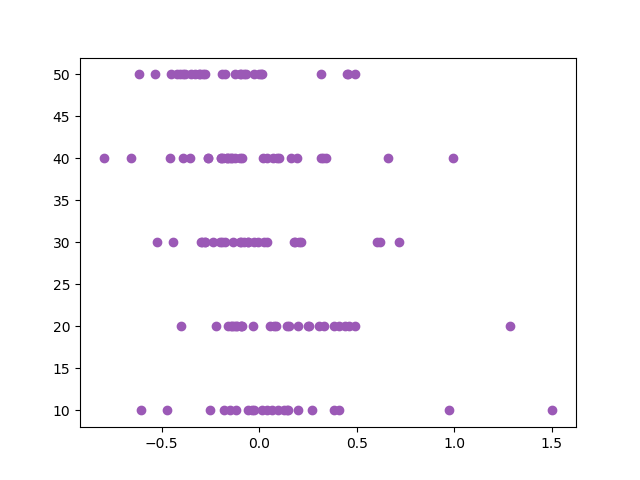

In [199]:
pl.figure()
pl.scatter(data1['x_test'].mean(axis=1), data1['y_test'])

<IPython.core.display.Javascript object>


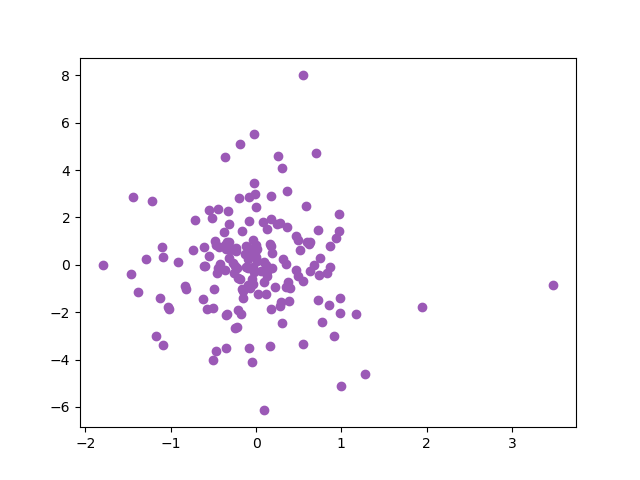

In [204]:
pl.figure()
pl.scatter(res1.regr.coef_, res2.regr.coef_)

<IPython.core.display.Javascript object>


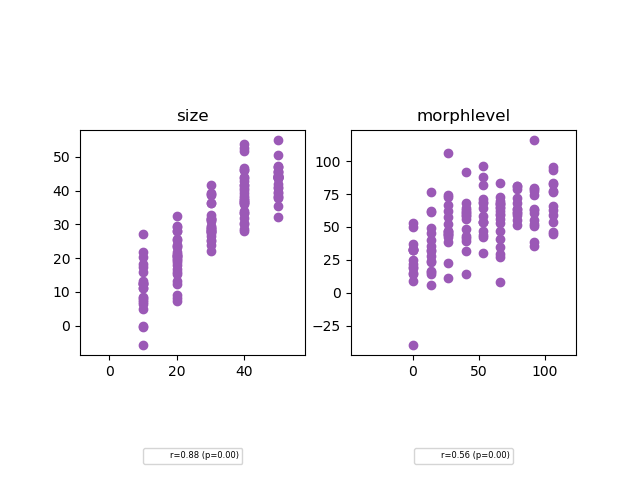

In [191]:
fig, axes = pl.subplots(1, 2)

ax = axes[0]
ax.set_title(regr_var1)
ax.scatter(res1.true, res1.prediction)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'r=%.2f (p=%.2f)' % (res1.pearsons_r, res1.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)

ax.set_aspect('equal')

ax = axes[1]
ax.set_title(regr_var2)
ax.scatter(res2.true, res2.prediction)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'r=%.2f (p=%.2f)' % (res2.pearsons_r, res2.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)

ax.set_aspect('equal')

#### Split by transform

In [153]:
split_transform = True
curr_transform = 'morphlevel'
predict_feature = 'morphlevel' if curr_transform=='size' else 'size'


In [154]:

all_transform_values = sorted(sdf[curr_transform].unique())
#curr_transform_value = 50
print "Testing %s:" % curr_transform, all_transform_values

curr_results = dict()
for curr_transform_value in all_transform_values:
    tested_configs = sdf[sdf[curr_transform]==curr_transform_value].index.tolist()

    labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)]
    trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
    all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
    included_trials = sorted(labels['trial'].unique(), key=natural_keys)
    trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
    print "N trials: %i" % len(trial_ixs)
    print "N configs: %i" % len(tested_configs)

    ##### Select data subset
    currdf = df.copy()
    currdf = currdf.iloc[trial_ixs]
    X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(currdf))

    #### Fit regressor
    targets1 = [sdf[predict_feature][cfg] for cfg in trial_configs]
    res1 = get_regr_stats(X, targets1)
    
    curr_results[curr_transform_value] = res1
    

Testing morphlevel: [0, 14, 27, 40, 53, 66, 79, 92, 106]
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5


<IPython.core.display.Javascript object>


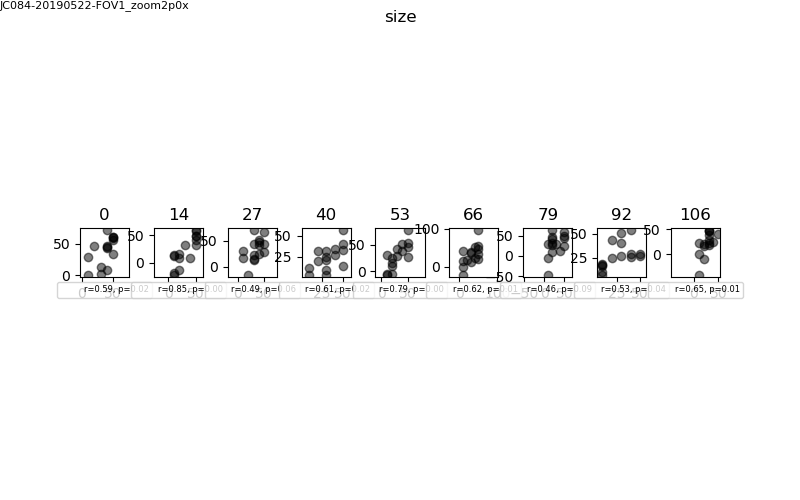

In [155]:
fig, axes = pl.subplots(1, len(all_transform_values), figsize=(8, 5))

for ax, trans_val in zip(axes.flat, sorted(all_transform_values)):
    res1 = curr_results[trans_val]
    ax.scatter(res1.true, res1.prediction, marker='o', c='k', alpha=0.5)
    maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
    minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
    ax.set_xlim([minv, maxv])
    ax.set_ylim([minv, maxv])
    ax.set_aspect('equal')
    ax.set_title(trans_val)
    pval_str = 'r=%.2f, p=%.2f' % (res1.pearsons_r, res1.pearsons_p)
    ax.plot(0, 0, alpha=0, label=pval_str)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)
              #ncol=3, fancybox=True, shadow=True)

pl.suptitle(predict_feature)
pl.subplots_adjust(left=0.1, wspace=0.5)
label_figure(fig, skey)


In [151]:
np.mean([0.12, 0.53, 0.42, 0.62, 0.32])

0.40199999999999997

In [16]:
import numpy as np
import seaborn as sns
from scipy import stats as spstats
from pipeline.python.utils import label_figure, natural_keys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model, preprocessing



In [134]:
def fit_lasso_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Lasso()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_ridge_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Ridge()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_linear_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

In [135]:
class Struct():
    pass


def get_regr_stats(X, ylabels, test_size=0.1, return_data=False, model='ols'):
    x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=test_size, random_state=0)
    if model=='ols':
        y_pred, regr = fit_linear_regr(x_train, y_train, x_test, y_test)
    elif model=='ridge':
        print("ridge")
        y_pred, regr = fit_ridge_regr(x_train, y_train, x_test, y_test)
    elif model=='lasso':
        print("lasso")
        y_pred, regr = fit_lasso_regr(x_train, y_train, x_test, y_test)
        
    results = Struct()
    results.pearsons_r, results.pearsons_p = spstats.pearsonr(y_test, y_pred)
    results.exp_var = metrics.explained_variance_score(y_test, y_pred)
    results.mse = metrics.mean_squared_error(y_test, y_pred)
    results.r2 = metrics.r2_score(y_test, y_pred, multioutput='uniform_average')
    results.regr = regr
    results.prediction = y_pred
    results.true = y_test
    
    if return_data:
        data = {'x_train': x_train,
                'x_test': x_test,
                'y_train': y_train,
                'y_test': y_test}
        
        return results, data
    return results


# Get regression for all datasets included

In [141]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True
model = 'lasso'
visual_areas = ['V1', 'Lm', 'Li']

In [67]:
regression_fpath = os.path.join(outdir, 'regression_stats_all.pkl')


In [68]:
with open(regression_fpath, 'rb') as f:
    results = pkl.load(f)

In [142]:
results = dict((visual_area, {regr_var1: {}, regr_var2: {}}) for visual_area in visual_areas)
RES = dict((visual_area, dict()) for visual_area in visual_areas)

In [155]:
for visual_area in visual_areas:
    dsets = sdata[(sdata['visual_area']==visual_area) & (sdata['experiment']=='blobs')]

    for (animalid, session, fov), g in dsets.groupby(['animalid', 'session', 'fov']):

        if '-'.join([animalid, session]) in excluded_sessions:
            continue
        if animalid == 'JC091' and session == '20191008':
            continue
        skey = '-'.join([animalid, session, fov])

        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        sizes = np.array(sorted(sdf['size'].unique()))
        morphs = np.array(sorted(sdf['morphlevel'].unique()))

        n_sizes = len(sdf['size'].unique())
        n_morphs = len(sdf['morphlevel'].unique()) 
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            pass

        rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                     response_type=response_type, responsive_test=responsive_test,
                                     responsive_thr=responsive_thr, n_stds=n_stds)
        rstats = rstats['nframes_above']

        # Get metrics for each condition
        estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T
        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        dflist = [pd.DataFrame(estats.gdf.get_group(roi).sort_values(by='trial')['dff']).reset_index(drop=True)\
                  for roi in rois_plot]
        df = pd.concat(dflist, axis=1)
        df.columns = rois_plot

        sdf = reformat_morph_values(exp.data.sdf)
        excluded_configs = []
        if exclude_controls:
            excluded_configs = sdf[sdf['morphlevel']==-1].index.tolist()
            sdf = sdf[sdf['morphlevel'] != -1]
        all_configs = [c for c in sdf.index.tolist() if c not in excluded_configs]

        if skey not in RES[visual_area].keys():
            RES[visual_area][skey] = {'morphlevel': {}, 'size': {}}
        # Split by size
        for regr_var in ['morphlevel', 'size']:
            
            hold_var = 'size' if regr_var=='morphlevel' else 'morphlevel'
            hold_vals = sorted(sdf[hold_var].unique())
            for hv in hold_vals:
                xdf = df.copy()
                tested_configs = sdf[sdf[hold_var]==hv].index.tolist()
                print '(%s)' % regr_var, hold_var, hv, len(tested_configs)
                
                # Get label info for tested configs:
                labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)] 
                
                # Get trial list of tested configs
                trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
                
                # Get trial names for included trials
                all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
                included_trials = sorted(labels['trial'].unique(), key=natural_keys)
                trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
                print len(trial_ixs)

                xdf = xdf.iloc[trial_ixs]
                X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(xdf))

                targets = [sdf[regr_var][cfg] for cfg in trial_configs]
                res = get_regr_stats(X, targets, model=model)

                results[visual_area][regr_var][hv] = res
                RES[visual_area][skey][regr_var][hv] = res
        

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 163 of 175 responsive cells.
(morphlevel) size 10.0 9
270
lasso
(morphlevel) size 20.0 9
270
lasso
(morphlevel) size 30.0 9
270
lasso
(morphlevel) size 40.0 9
270
lasso
(morphlevel) size 50.0 9
270
lasso
(size) morphlevel 0 5
150
lasso
(size) morphlevel 14 5
150
lasso
(size) morphlevel 27 5
150
lasso
(size) morphlevel 40 5
150
lasso
(s

... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_3b3744_traces001_1990cb_traces001_58a59f_traces001_c760ae_traces001_00f36c_traces001_6f6bcc_traces001_13f7f0/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 202 of 211 responsive cells.
(morphlevel) size 10.0 9
297
lasso
(morphlevel) size 20.0 9
297
lasso
(morphlevel) size 30.0 9
297
lasso
(morphlevel) size 40.0 9
297
lasso
(morphlevel) size 50.0 9
297
lasso
(size) morphlevel 0 5
165
lasso
(size) morphlevel 14 5
165
lasso
(size) morphlevel 27 5
165
lasso
(size) morphlevel 40 5
165
lasso
(s

... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_99ce14_traces001_328664_traces001_f2e06a_traces001_26306f_traces001_7fd9a8_traces001_9f1071/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 169 of 170 responsive cells.
(morphlevel) size 10.0 9
270
lasso
(morphlevel) size 20.0 9
270
lasso
(morphlevel) size 30.0 9
270
lasso
(morphlevel) size 40.0 9
270
lasso
(morphlevel) size 50.0 9
270
lasso
(size) morphlevel 0 5
150
lasso
(size) morphlevel 14 5
150
lasso
(size) morphlevel 27 5
150
lasso
(size) morphlevel 40 5
150
lasso
(size) morphlevel 53 5
150
lasso
(size) morphlevel 66 5
150

... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 22 of 22 responsive cells.
(morphlevel) size 10.0 9
171
lasso
(morphlevel) size 20.0 9
171
lasso
(morphlevel) size 30.0 9
171
lasso
(morphlevel) size 40.0 9
171
lasso
(morphlevel) size 50.0 9
171
lasso
(size) morphlevel 0 5
95
lasso
(size) morphlevel 14 5
95
lasso
(size) morphlevel 27 5
95
lasso
(size) morphlevel 40 5
95
lasso
(size) morphlevel 53 5
95
lasso
(size) morphlevel 66 5
95
l

In [156]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00/linear-regression'

In [157]:
regression_fpath = os.path.join(outdir, 'regr-%s_split-trans.pkl' % model)
with open(regression_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
    
regression_fpath = os.path.join(outdir, 'regr-%s_split-trans_by-session.pkl' % model )
with open(regression_fpath, 'wb') as f:
    pkl.dump(RES, f, protocol=pkl.HIGHEST_PROTOCOL)

In [196]:
[np.mean([v.r2 for s in RES[visual_area].keys() \
         for k, v in RES[visual_area][s]['size'].items()]) for visual_area in visual_areas]




[0.6000118816515418, 0.5450140492829405, 0.28673818018544545]

In [203]:
pd.DataFram
    RES[visual_area][s]['morphlevel']


{10.0: <__main__.Struct instance at 0x2ab300dcc200>,
 20.0: <__main__.Struct instance at 0x2ab2fc1a9f38>,
 30.0: <__main__.Struct instance at 0x2ab2ffd0b950>,
 40.0: <__main__.Struct instance at 0x2ab2feb1d950>,
 50.0: <__main__.Struct instance at 0x2ab300dcc518>}

In [202]:
[np.mean([v.r2 for s in RES[visual_area].keys() \
         for k, v in RES[visual_area][s]['morphlevel'].items()]) for visual_area in visual_areas]




[0.21670817251911956, 0.04111398147636445, -0.11288062061003243]

In [189]:
[np.mean([v.r2 for s, v in results[visual_area]['size'].items()]) for visual_area in visual_areas]



[0.5191854645624494, 0.4191833686744402, -0.10376904786561784]

In [190]:
[np.mean([v.r2 for s, v in results[visual_area]['morphlevel'].items()]) for visual_area in visual_areas]


[0.20355698109752635, -0.013387328487853688, -0.08557789135215192]

<IPython.core.display.Javascript object>


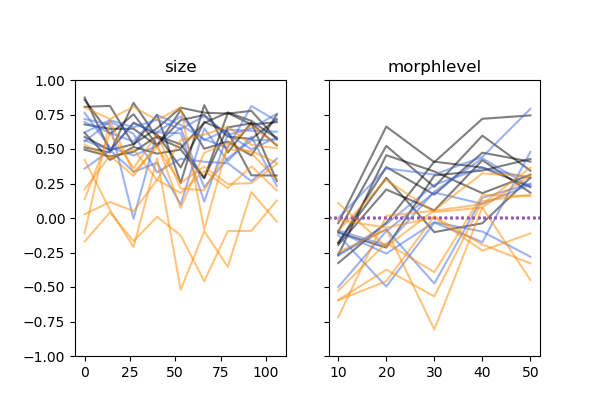

(-1, 1)

In [253]:
r2_morph=dict((visual_area, []) for visual_area in visual_areas)
r2_size=dict((visual_area, []) for visual_area in visual_areas)
fig, axes = pl.subplots(1,2, figsize=(6,4), sharey=True)
for visual_area in visual_areas:
    for skey, res in RES[visual_area].items():
        axes[0].set_title('size')
        t_vals = sorted(res['size'].keys())
        r2_vals = [res['size'][t].r2 for t in sorted(t_vals)]
        axes[0].plot(t_vals, r2_vals, c=area_colors[visual_area], alpha=0.5)
        r2_size[visual_area].append(r2_vals)
        
        axes[1].set_title('morphlevel')
        t_vals = sorted(res['morphlevel'].keys())
        r2_vals = [res['morphlevel'][t].r2 for t in sorted(t_vals)]
        axes[1].plot(t_vals, r2_vals, c=area_colors[visual_area], alpha=0.5)
        r2_morph[visual_area].append(r2_vals)
        axes[1].axhline(y=0, linestyle=':')
pl.subplots_adjust(top=0.8)
pl.ylim([-1, 1])



In [229]:
np.array(r2_morph['V1']).mean(axis=0)

array([-0.17414137,  0.28237006,  0.22572001,  0.38239743,  0.36719474])

In [232]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())

In [235]:
sems_morphs

array([0.03320405, 0.10283308, 0.06330468, 0.08326516, 0.06124847])

<IPython.core.display.Javascript object>


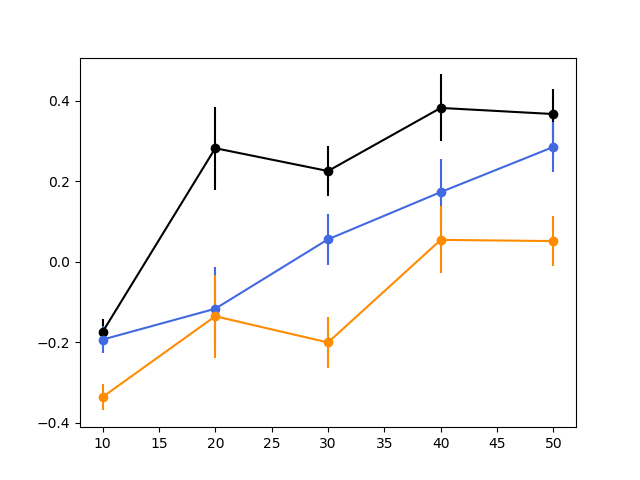

In [249]:
fig, ax = pl.subplots()

for visual_area in visual_areas:
    mean_morphs = np.array(r2_morph[visual_area]).mean(axis=0)
    sem_morphs = spstats.sem(np.array(r2_morph[visual_area]), axis=0)

    ax.plot(tested_sizes, mean_morphs, c=area_colors[visual_area], marker='o', lw=0)
    ax.errorbar(tested_sizes, mean_morphs, yerr=sems_morphs, c=area_colors[visual_area])

In [112]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [59]:
x = results[visual_area]['morphlevel'][0]

In [60]:
x.exp_var

0.07599395460821934

<IPython.core.display.Javascript object>


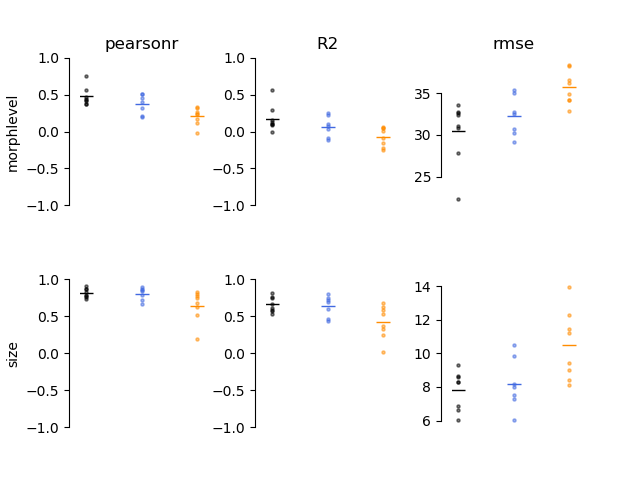

In [115]:
fig, axes = pl.subplots(2, 3, sharex=True)
marker= '.'
marker_size = 20
alpha=0.5
for vi, visual_area in enumerate(visual_areas): #results.keys():
    facecolor = area_colors[visual_area] #'none'
    values = [e.pearsons_r for e in results[visual_area]['morphlevel']]
    axes[0, 0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 0].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
    values = [e.pearsons_r for e in results[visual_area]['size']]
    axes[1, 0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[1, 0].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    axes[0, 0].set_title('pearsonr')
    axes[0, 0].set_ylabel('morphlevel')
    axes[1, 0].set_ylabel('size')
    axes[0, 0].set_ylim([-1, 1])
    axes[1, 0].set_ylim([-1, 1])

    values = [e.r2 for e in results[visual_area]['morphlevel']]
    axes[0, 1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 1].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    values = [e.r2 for e in results[visual_area]['size']]
    axes[1, 1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[1, 1].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
    axes[0, 1].set_title('R2')
    axes[0, 1].set_ylim([-1, 1]) #; axes[0, 1].set_yticks([0, 1]);
    axes[1, 1].set_ylim([-1, 1]) #; axes[1, 1].set_yticks([0, 1]);

    values = [np.sqrt(e.mse) for e in results[visual_area]['morphlevel']]
    axes[0, 2].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 2].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
    values = [np.sqrt(e.mse) for e in results[visual_area]['size']]
    axes[1, 2].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 2].set_title('rmse')
    axes[1, 2].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
sns.despine(bottom=True, trim=True, offset=8)
for ax in axes.flat:
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xticklabels([])
pl.subplots_adjust(wspace=0.5, hspace=0.5)
pl.savefig(os.path.join(outdir, 'linear-regr_morph-size_stats-ols-all.svg'))

In [97]:
[np.mean([e.r2 for e in results[visual_area]['size']]) for visual_area in visual_areas]


[0.6617785265111145, 0.63912694161806, 0.42351515866434963]

In [98]:
[spstats.sem([e.r2 for e in results[visual_area]['size']]) for visual_area in visual_areas]


[0.03771892358601259, 0.05345380605170954, 0.07897196284409934]

In [99]:
 [e.r2 for e in results['Li']['size']]

[0.6832860125687502,
 0.5323160104538257,
 0.32341004185219635,
 0.628068912970613,
 0.3643060269507961,
 0.5808337881744017,
 0.2535284724193354,
 0.02237200392487837]

<IPython.core.display.Javascript object>


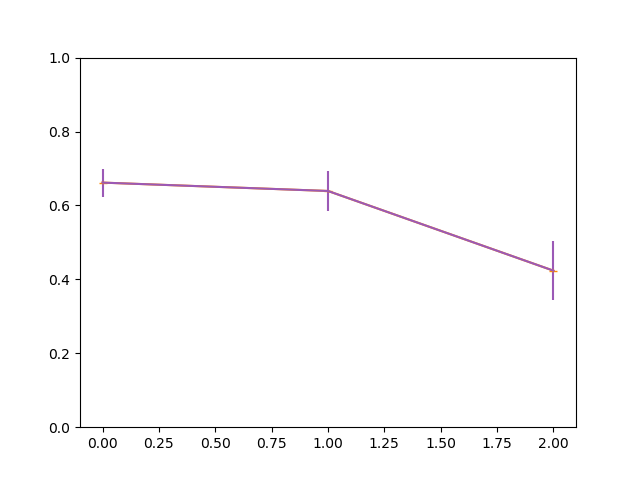

(0, 1)

In [122]:
fig, ax = pl.subplots()
#for vi, visual_area in enumerate(visual_areas):
    #vals = [e.r2 for e in results[visual_area]['size']]
    #ax.scatter([vi for _ in range(len(vals))], vals, marker='.', c=area_colors[visual_area], alpha=0.5)
meanvals = [np.mean([e.r2 for e in results[visual_area]['size']]) for visual_area in visual_areas]
semvals = [spstats.sem([e.r2 for e in results[visual_area]['size']]) for visual_area in visual_areas]

ax.plot([0, 1, 2], meanvals, marker='_', c=area_colors[visual_area])
ax.errorbar([0, 1, 2], meanvals, yerr=semvals)

ax.set_ylim([0, 1])

<IPython.core.display.Javascript object>


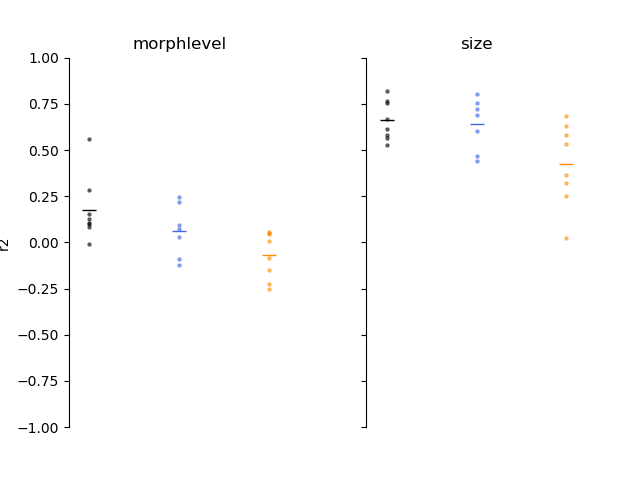

In [116]:
fig, axes = pl.subplots(1, 2, sharex=False, sharey=True)
marker= '.'
marker_size = 20
alpha=0.5
curr_metric = 'r2'

for vi, visual_area in enumerate(visual_areas): #results.keys():
    facecolor = area_colors[visual_area] #'none'
    if curr_metric == 'RMSE':
        values = [np.sqrt(e.mse) for e in results[visual_area]['morphlevel']]
    else:
        values = [e.r2 for e in results[visual_area]['morphlevel']]
        
    axes[0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1., c=facecolor)

    if curr_metric == 'RMSE':
        values = [np.sqrt(e.mse) for e in results[visual_area]['size']]
    else:
        values = [e.r2 for e in results[visual_area]['size']]
        
    axes[1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[1].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1., c=facecolor)

    axes[0].set_title('morphlevel')
    axes[1].set_title('size')
    axes[0].set_ylabel(curr_metric)
if curr_metric not in ['RMSE', 'MSE']:
    axes[0].set_ylim([-1, 1])
    axes[0].set_ylim([-1, 1])
else:
    ymax = max([axes[0].get_ylim()[-1], axes[1].get_ylim()[-1]])
    axes[0].set_ylim([0, ymax])
    axes[1].set_ylim([0, ymax])


sns.despine(bottom=True, trim=True, offset=8)
for ax in axes.flat:
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xticklabels([])
pl.subplots_adjust(wspace=0.5, hspace=0.5)
#pl.savefig(os.path.join(outdir, 'linear-regr_morph-size_stats.png'))

In [144]:
exp.data.labels.shape

(214400, 8)

In [145]:
avg_tcorrs = {}
for visual_area, corr_mats in trial_corrs.items():
    avg_tcorrs[visual_area] = [np.mean(np.abs(np.tril(c, -1))) for c in corr_mats]
avg_tcorrs

1600

In [146]:
c1 = avg_tcorrs['V1']
c2 = avg_tcorrs['Lm']
c3 = avg_tcorrs['Li']

1440

In [ ]:
# Shapiro-Wilk normality test 
spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) 

In [ ]:
# Levene variance test  
spstats.levene(c1, c2, c3)

In [ ]:
F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

In [ ]:
scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

In [ ]:
import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

In [123]:
import scipy.stats as spstats

In [124]:
Rvals = {}
Pvals = {}
for visual_area in visual_areas:
    coefs = [spstats.pearsonr(mp.regr.coef_, sz.regr.coef_)\
                   for mp, sz in zip(results[visual_area]['morphlevel'], results[visual_area]['size'])]
    mean_pearsonsr = np.mean([c[0] for c in coefs])
    std_pearsonsr = spstats.sem([c[0] for c in coefs])
    Rvals[visual_area] = [c[0] for c in coefs]
    Pvals[visual_area] = [c[1] for c in coefs]
    
    print visual_area, mean_pearsonsr, std_pearsonsr

V1 0.040158646103827224 0.02950113574930135
Lm 0.02233161624197456 0.03217302396784569
Li 0.03789768392006382 0.035537905924960034


<IPython.core.display.Javascript object>


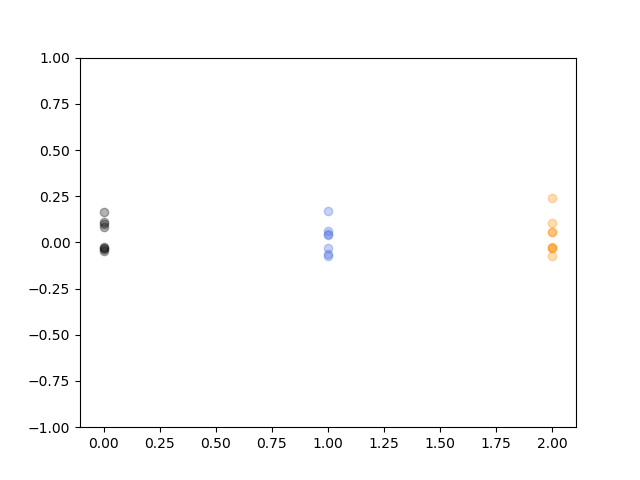

(-1, 1)

In [129]:
pl.figure()
for vi, visual_area in enumerate(visual_areas):
    vals = Rvals[visual_area]
    pl.scatter([vi for _ in range(len(vals))], vals, marker='o', 
               color=area_colors[visual_area], alpha=0.3)
    
pl.ylim([-1, 1])